In [32]:
import pandas as pd
# Python modules used for API access...
from chembl_webresource_client.new_client import new_client
from tqdm import tqdm
import pickle
import numpy as np
from functions import PROCESS
import matplotlib.pyplot as plt

In [ ]:
"""
Module I: Data retrieval and processing
Use this block to retrieve/process your data by providing a drug file
"""
drugs = pd.read_csv('data/KIBA_drugs.csv')

# Initialize PROCESS object
obj = PROCESS(drugs)
# Step 1: Extaract terget data for 52k drugs from CHEMBL
main_dict = obj.extractDrugTargets(drugs['drugs'].tolist())
obj.save_obj(main_dict, 'data/main_dict.pkl')

# Step 2: Extract Drug-Target pairs for Homo-Sapiens with IC50 values
DTI = obj.getDTI(main_dict)

# Step 3: Get mapping from CHEMBL to uniprot and save at data/out.txt
obj.chembl2uniprot('data/DTI.csv', 'data/out.txt')

# Step 4: Screen Data based on units, sequence-availiability
final_DTI = obj.screenDTI(DTI, 'data/chembl2uniprot.txt', 'final_clean_DTI.csv')

In [ ]:
"""
Module II: Feature retrieval and processing
Use this block to retrieve/process your data by providing a drug file
"""
# Extract drug descriptors
attribs = [
      'MaxAbsPartialCharge', 'MinPartialCharge', 'MinAbsPartialCharge', 'HeavyAtomMolWt', 'MaxAbsEStateIndex', 'NumRadicalElectrons',
      'NumValenceElectrons', 'MinAbsEStateIndex', 'MaxEStateIndex', 'MaxPartialCharge', 'MinEStateIndex', 'ExactMolWt', 'MolWt', 'BalabanJ',
      'BertzCT', 'Chi0', 'Chi0n', 'Chi0v', 'Chi1', 'Chi1n', 'Chi1v', 'Chi2n', 'Chi2v', 'Chi3n', 'Chi3v', 'Chi4n', 'Chi4v',
      'HallKierAlpha', 'Ipc', 'Kappa1', 'Kappa2', 'Kappa3', 'LabuteASA', 'PEOE_VSA1', 'PEOE_VSA10', 'PEOE_VSA11', 'PEOE_VSA12', 'PEOE_VSA13', 
      'PEOE_VSA14', 'PEOE_VSA2', 'PEOE_VSA3', 'PEOE_VSA4', 'PEOE_VSA5', 'PEOE_VSA6', 'PEOE_VSA7', 'PEOE_VSA8', 'PEOE_VSA9', 'SMR_VSA1',
      'SMR_VSA10', 'SMR_VSA2', 'SMR_VSA3', 'SMR_VSA4', 'SMR_VSA5', 'SMR_VSA6', 'SMR_VSA7', 'SMR_VSA8', 'SMR_VSA9', 'SlogP_VSA1', 'SlogP_VSA10', 'SlogP_VSA11', 'SlogP_VSA12',      'SlogP_VSA2','SlogP_VSA3', 'SlogP_VSA4', 'SlogP_VSA5', 'SlogP_VSA6', 'SlogP_VSA7', 'SlogP_VSA8', 'SlogP_VSA9', 'TPSA', 'EState_VSA1', 'EState_VSA10', 
      'EState_VSA11', 'EState_VSA2',      'EState_VSA3', 'EState_VSA4', 'EState_VSA5', 'EState_VSA6', 'EState_VSA7', 'EState_VSA8', 'EState_VSA9',
      'VSA_EState1', 'VSA_EState10', 'VSA_EState2', 'VSA_EState3', 'VSA_EState4', 'VSA_EState5', 'VSA_EState6', 'VSA_EState7', 'VSA_EState8',
      'VSA_EState9', 'FractionCSP3', 'HeavyAtomCount', 'NHOHCount', 'NOCount', 'NumAliphaticCarbocycles', 'NumAliphaticHeterocycles',
      'NumAliphaticRings', 'NumAromaticCarbocycles', 'NumAromaticHeterocycles', 'NumAromaticRings', 'NumHAcceptors', 'NumHDonors', 'NumHeteroatoms',
      'NumRotatableBonds', 'NumSaturatedCarbocycles','NumSaturatedHeterocycles', 'NumSaturatedRings', 'RingCount', 'MolLogP', 'MolMR'
    ]

fset_mol=pd.DataFrame()
for chembl_id in tqdm(drugs['drugs']):
    descriptors, status = obj.mol2des(chembl_id, attribs)
    if status:
        fset_mol = fset_mol.append(descriptors)
fset_mol.to_csv('fset_drugs.csv')

# Extract protein descriptors
des = obj.extractProteinDes('AAC', 'data/chembl2uniprot.txt')

In [269]:
final_DTI = pd.read_csv('data/final_clean_DTI.csv')[['target','drug','IC50','unit']]
final_DTI['unit'].unique()

array(['uM', 'nM', 'mM', 'pM'], dtype=object)

In [271]:
# Normalize all activity units
for i in tqdm(range(len(final_DTI))):
    if final_DTI.at[i,'unit']=='pM':
        final_DTI.at[i,'IC50']=final_DTI.at[i,'IC50']*1000000   # pM to uM
        final_DTI.at[i,'unit']='uM'
    elif final_DTI.at[i,'unit']=='nM':
        final_DTI.at[i,'IC50']=final_DTI.at[i,'IC50']*1000  # nM to uM
        final_DTI.at[i,'unit']='uM'
    elif final_DTI.at[i,'unit']=='mM':
        final_DTI.at[i,'IC50']=final_DTI.at[i,'IC50']/1000  # mM to uM
        final_DTI.at[i,'unit']='uM'
    elif final_DTI.at[i,'unit']=='uM':
        pass

final_DTI['unit'].unique()

100%|██████████| 77396/77396 [00:03<00:00, 22111.57it/s]


array(['uM'], dtype=object)

In [137]:
eknumber = final_DTI['IC50'][final_DTI['IC50']<0.1]
thikthak = final_DTI['IC50'][(final_DTI['IC50']>0.1)&(final_DTI['IC50']<30)]
khatam   =  final_DTI['IC50'][final_DTI['IC50']>30]

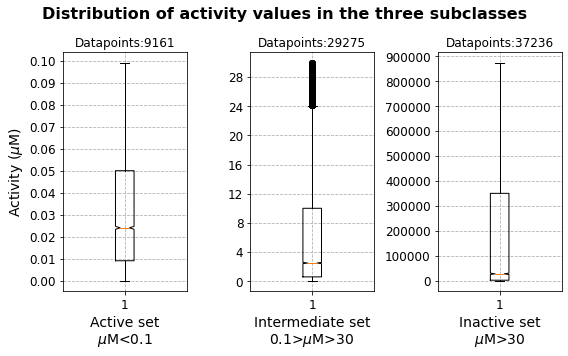

In [256]:
fig, ax = plt.subplots(1,3,figsize=(8,5))
fig.suptitle('Distribution of activity values in the three subclasses',fontweight = 'bold',  fontsize=16)

ax[0].set_title('Datapoints:%s'%(collections.Counter(final_DTI['IC50']<0.1)[1]))
ax[0].boxplot(final_DTI['IC50'][final_DTI['IC50']<0.1], notch=True)
ax[0].set_yticks(np.arange(0, 0.11, 0.01))
ax[0].set_ylabel('Activity ('+ r'$\mu$'+'M)', fontsize = 14)

ax[1].set_title('Datapoints:%s'%(collections.Counter((final_DTI['IC50']>0.1)&(final_DTI['IC50']<30))[1]))
ax[1].boxplot(final_DTI['IC50'][(final_DTI['IC50']>0.1)&(final_DTI['IC50']<30)], notch=True)
ax[1].set_yticks(np.arange(0, 30, 4))

ax[2].set_title('Datapoints:%s'%(collections.Counter(final_DTI['IC50']>30)[1]))
ax[2].boxplot(final_DTI['IC50'][final_DTI['IC50']>30], notch=True, showfliers=False)
ax[2].set_yticks(np.arange(0, 1000000, 100000))

for axis,name in zip(ax,[r'Active set%s$\mu$M<0.1'%'\n', r'Intermediate set%s0.1>$\mu$M>30'%'\n', r'Inactive set%s$\mu$M>30'%'\n']):
    axis.set_xlabel(name, fontsize=14)
    axis.grid(linestyle='--')
    axis.tick_params(axis="x", labelsize=12)
    axis.tick_params(axis="y", labelsize=12) 

fig.tight_layout()
plt.show()